# Detecting LLM-Generated Text with Binoculars

[Spotting LLMs With Binoculars: Zero-Shot Detection of Machine-Generated Text](https://arxiv.org/abs/2401.12070)

![Credit to authors Abhimanyu Hans, Avi Schwarzschild, Valeriia Cherepanova, Hamid Kazemi, Aniruddha Saha, Micah Goldblum, Jonas Geiping, and Tom Goldstein.](authors.png)

The ability to detect AI-generated text is an important issue, not only because of academic integrity issues, but also due to misinformation, security, and copyright concerns. A new method for detection of machine-generated text, called *Binoculars*, achieves over 90% accuracy in detection at a 0.01% false positive rate. In this notebook, I annotate key parts of the paper, explaining the mechanisms behind this new method and implementing it piece-by-piece. Code from the original paper is available [here](https://github.com/ahans30/Binoculars/tree/main) and this Jupyter Notebook is available [here](https://github.com/dmicz/devblognotebooks).

![The new Binoculars paper shows significant improvment from previous SoTA models.](paper_detection_stats.png)

# Table of Contents
- [LLM Detection](#llm-detection)
- [Part 1: Understanding *Binoculars*](#part-1-understanding-binoculars)
    - [Perplexity](#perplexity)
    - [Motivation](#motivation)
- [Part 2: Implementation](#part-2-implementation)
    - [Prelims](#prelims)
    - [Observer and Performer Models](#observer-and-performer-models)
    - [Perplexity and cross-perplexity](#perplexity-and-cross-perplexity)
    - [Binoculars Score](#binoculars-score)
- [Part 3: Further Investigation](#part-3-further-investigation)
- [Conclusion](#conclusion)

# LLM Detection

The motivation behind LLM Detection is harm reduction, to trace text origins, block spam, and identify fake news produced by LLMs. *Preemptive detection* methods attempt to "watermark" generated text, but requires full control of the generating models, which already seems to be impossible. Therefore, more recent works have been on *post-hoc detection* methods, which could be used without the cooperation of the text's author. The paper's authors suggest that there are two main groups for post-hoc detectors, the first being finetuning a pretrained language model to perform binary classification. There are many additional techniques that make this approach more effective, but all implementations will require training on text produced by the target model, which is both computationally expensive and limited by the number of new models that are being open-sourced.

The second group uses statistical signatures of machine-generated text, with the aim of zero-shot learning. This would allow for the detection of a wide range of models, with little to no training data. These methods use measures such as perplexity, perplexity curvature, log rank, intrinsic dimensionality, and n-gram analysis. The Binoculars paper proposes a focus on low false positive rate (FPR) and high performance on out-of-domain samples, rather than focusing on classifier AUCs for the high-stakes application of LLM detection.

# Part 1: Understanding *Binoculars*

## Perplexity

![Diagram of LLM inference](diagram1.png)

LLMs parse a string of characters $s$ into tokens using a tokenizer $T$, providing a list of tokens $\vec{x}$. Given this input of tokens, a language model $\mathcal{M}$ predicts the token that is next in the sequence by outputting a probability distribution over its vocabulary, $V$:

$$
    \mathcal{M}(T(s))=\mathcal{M}(\vec{x})=Y \\
    Y_{ij} = P(v_j | x_{0:i-1})\,\text{for all}\,j\in V
$$

A natural way to then predict whether or not text was generated by a machine is to measure how likely it is that the language model $\mathcal{M}$ generates each token in $s$, given all the tokens before it. *Perplexity* is a common baseline that measures this, and we define log-perplexity ($\log \text{PPL}$) as the average log-likelihood of all tokens in $s$:

$$
    \log \text{PPL}_{\mathcal{M}}(s)=-\frac{1}{L} \sum^L_{i=1}\log(Y_{ix_i}), \\
    \text{where}\,\vec{x}=T(s), Y=\mathcal{M}(\vec{x})\,\text{and $L=$ number of tokens in $s$}
$$

Perplexity is a reasonable first approach for a couple of reasons:
- Humans often produce higher perplexity text than LLMs ("more surprising").
- The loss function LLMs are trained on *is* the log perplexity, as the models are effectively asked to reproduce its test data, given only a prefix of it.

Perplexity, however, is insufficient alone as an approach to detect LLMs. There are many prompts that may produce high perplexity output, such as those that introduce highly specialized domain knowledge, complex vocabulary, new ideas, or prompts that create output that is highly dependent on the context. Tuning the perplexity threshold high enough to catch these LLM outputs inevitably raises the false positive rate for output that is produced by humans, but is more predictable and less domain specific.

As an example from the original paper, prompts such as "1, 2, 3," have the lowest perplexity with completions such as "4, 5, 6." However, a prompt about a capybara that is also an astrophysicist produces surprising output, which has a high perplexity. With context, the perplexity of the output would be much lower, but LLM detection in practice must rely on not having access to the language model's context or prompt.

## Motivation

*Binoculars* uses a mechanism motivated by the aforementioned problems to estimate "baseline perplexity" that was induced by the context and prompt of a text. By comparing actual perplexity to the expected perplexity, we have a much better idea of whether or not an LLM produced the text in question. This is because we can expect the perplexity of human-written text to be *even higher* perplexity than that of a machine, given the same prompt and context.

To measure the baseline perplexity, the authors introduce *cross-perplexity*, which is cross-entropy measured between two models on the same string $s$:

$$
    \log\text{X-PPL}_{\mathcal{M}_1,\mathcal{M}_2}(s)=-\frac{1}{L}\sum^L_{i=1}\mathcal{M}_1(s)_i\cdot\log(\mathcal{M}_2(s)_i)
$$

NB: The measure relies on the models having the same tokenizer $T$.

This score in essence measures how surprised $\mathcal{M}_1$ is by the token predictions of $\mathcal{M}_2$, therefore providing some sense of how much perplexity a machine-generated token may have. Combining this with perplexity, we reach the proposed *Binoculars* score:

$$
    B_{\mathcal{M}_1\mathcal{M}_2}(s)=\frac{\log\text{PPL}_{\mathcal{M}_1}(s)}{\log\text{X-PPL}_{\mathcal{M}_1,\mathcal{M}_2}(s)}
$$

With this mechanism, $\mathcal{M}_1$ acts as the *observer* model, while $\mathcal{M}_2$ acts as the *performer* model. The score is then a comparison of how surprising the producer of the string is and how surprising the performer model's predictions of the string are.

# Part 2: Implementation

## Prelims



In [1]:
%pip install sentencepiece transformers torch numpy gradio gradio_client

You should consider upgrading via the '/scratch/dkm6080/.local/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from typing import Union
import numpy as np
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer

/scratch/dkm6080/.local/lib/python3.9/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
# Change according to hardware
DEVICE_1 = "cuda:0"
DEVICE_2 = "cpu"

## Observer and Performer Models

We begin implementation by selecting the two language models, the observer ($\mathcal{M}_1$) and performer ($\mathcal{M}_2$). This implementation will stick to the choices<sup id="fnref:1"><a href="#fn:1">1</a></sup> of Falcon-7B-instruct as an observer and Falcon-7B as a performer, which is the highest performing combination in the *Binoculars* paper. We first verify that both tokenizers are identical.

In [4]:
torch.set_grad_enabled(False)

observer_name = "tiiuae/falcon-7b-instruct"
performer_name = "tiiuae/falcon-7b"

identical_tokens = (AutoTokenizer.from_pretrained(observer_name).vocab ==
                    AutoTokenizer.from_pretrained(performer_name).vocab)

identical_tokens

True

In [5]:
observer_model = AutoModelForCausalLM.from_pretrained(observer_name,
                                                                   device_map={"": DEVICE_1},
                                                                   trust_remote_code=True,
                                                                   torch_dtype=torch.bfloat16)

performer_model = AutoModelForCausalLM.from_pretrained(performer_name,
                                                                     device_map={"": DEVICE_2},
                                                                     trust_remote_code=True,
                                                                     torch_dtype=torch.bfloat16)

observer_model.eval()
performer_model.eval()

tokenizer = AutoTokenizer.from_pretrained(observer_name)


A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- configuration_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b-instruct:
- modeling_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/scratch/dkm6080/.local/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- configuration_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- modeling_falcon.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

We then instantiate the tokenizer for both models, which turns the input text into several tokens.

In [6]:
def tokenize(text):
    return tokenizer(text, return_tensors="pt")

tokenize("Hello, my dog is cute")

{'input_ids': tensor([[9856,   23,  491, 3696,  304, 7209]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

## Perplexity and cross-perplexity

To implement perplexity, we need to get the observer model's log probability for every word in the sequence. Using the observer model, we first obtain the logits for some string.

In [7]:
@torch.inference_mode()
def get_logits(encodings):
    observer_logits = observer_model(**encodings.to(DEVICE_1)).logits
    performer_logits = performer_model(**encodings.to(DEVICE_2)).logits
    return observer_logits, performer_logits

encoding = tokenize('''Dr. Capy Cosmos, a capybara unlike any other, astounded the scientific community with his 
groundbreaking research in astrophysics. With his keen sense of observation and unparalleled ability to interpret 
cosmic data, he uncovered new insights into the mysteries of black holes and the origins of the universe. As he 
peered through telescopes with his large, round eyes, fellow researchers often remarked that it seemed as if the 
stars themselves whispered their secrets directly to him. Dr. Cosmos not only became a beacon of inspiration to 
aspiring scientists but also proved that intellect and innovation can be found in the most unexpected of creatures.'''[:100])


observer_logits, performer_logits = get_logits(encoding)
observer_logits, performer_logits

(tensor([[[-23.1250, -18.1250,  -9.6250,  ..., -10.6875, -12.1250,  -9.1875],
          [-13.7500, -19.6250, -14.1875,  ..., -15.0000, -16.6250, -10.9375],
          [-13.0625, -16.8750, -14.8750,  ..., -17.8750, -15.3750, -14.5000],
          ...,
          [-12.9375, -12.3125, -12.6875,  ..., -16.0000, -14.8750, -18.0000],
          [-16.7500, -15.5000, -16.2500,  ..., -16.7500, -18.3750, -15.8125],
          [-16.1250, -17.6250, -14.5000,  ..., -18.1250, -19.1250, -17.2500]]],
        device='cuda:0', dtype=torch.bfloat16),
 tensor([[[-20.3750, -21.0000, -14.5625,  ..., -13.2500, -15.8750,  -8.5625],
          [-13.0625, -18.7500, -15.1875,  ..., -15.3125, -17.1250, -11.5625],
          [-12.3750, -17.6250, -16.6250,  ..., -17.3750, -16.1250, -14.3125],
          ...,
          [-10.9375, -12.4375, -11.9375,  ..., -14.1875, -14.6875, -16.6250],
          [-14.6250, -13.8750, -16.7500,  ..., -17.6250, -19.1250, -15.6250],
          [-13.6250, -15.5000, -14.5625,  ..., -18.5000, -19.0

In [8]:
encoding.input_ids.shape, observer_logits.shape

(torch.Size([1, 26]), torch.Size([1, 26, 65024]))

These logits are in the shape of $B \times S \times V$, where $B$ is the batch size, $S$ is the sequence token length, and $V$ is the size of the vocabulary. Because we are only processing a single string, the batch size is 1, and the first 100 characters were tokenized into 26 tokens. We are interested in the logits of each token in the sequence (which provides a prediction of the next token) and we want to $S$ vectors of size $V$ (in this case, ~65k) that contains the log probabilities of each of the tokens in the vocabulary.

In [9]:
S = observer_logits.shape[-2]
V = observer_logits.shape[-1]

observer_logits[..., :-1, :].contiguous().shape

torch.Size([1, 25, 65024])

We then compare these to the true next tokens in the sequence (from the encoding of the string), ignoring the first token because it is not being predicted.

In [10]:
encoding.input_ids[..., 1:].shape

torch.Size([1, 25])

We will ignore the attention mask for now, but it's a key component later once we use larger batches. To compute the perplexity, we use the equation written earlier:

$$
    \log \text{PPL}_{\mathcal{M}}(s)=-\frac{1}{L} \sum^L_{i=1}\log(Y_{ix_i}), \\
    \text{where}\,\vec{x}=T(s), Y=\mathcal{M}(\vec{x})\,\text{and $L=$ number of tokens in $s$}
$$

Thankfully, PyTorch provides a class for this, `torch.nn.CrossEntropyLoss`. The class can then be called with the model outputs with shape $(S, V)$ and the target output in the shape of $(S)$. We transpose the logit tensor's last two dimensions to match this shape.

In [11]:
loss = torch.nn.CrossEntropyLoss(reduction='none')

ppl = loss(observer_logits[..., :-1, :].contiguous().transpose(1, 2).to("cpu"), 
     encoding.input_ids[..., 1:].contiguous().to("cpu")).float()

ppl, ppl.sum(1)

(tensor([[ 0.7148,  9.8750,  6.0312,  9.8125,  1.8359,  2.9688,  1.9375,  6.9375,
           0.0430,  0.0270, 11.5000,  0.2676,  0.1396,  0.3066,  9.0625,  1.7656,
           1.1250,  2.4531,  0.7109,  1.0859,  1.4297,  4.7188,  9.6875,  5.5938,
           8.8750]]),
 tensor([98.9049]))

From this, we get a measure of how "surprising" each token is to the observer model when performing next-token prediction and sum it together. While some tokens have a perplexity as low as 0.02, others are above 10.

We now implement cross-perplexity by running the same cross entropy function, except the target tensor is no longer a one-hot vector (the observed next token given by the user), but rather the softmax of the observer's logits.

In [12]:
softmax = torch.nn.Softmax(dim=-1)

performer_probs = softmax(performer_logits).view(-1, V)

performer_probs, performer_probs.shape

(tensor([[5.8265e-12, 3.1122e-12, 1.9500e-09,  ..., 7.2177e-09, 5.2387e-10,
          7.8604e-07],
         [7.5903e-08, 2.5648e-10, 9.0804e-09,  ..., 7.9744e-09, 1.3024e-09,
          3.4086e-07],
         [6.6124e-08, 3.4743e-10, 9.4587e-10,  ..., 4.4565e-10, 1.5571e-09,
          9.5461e-09],
         ...,
         [1.3039e-07, 2.8987e-08, 4.7730e-08,  ..., 5.0350e-09, 3.0559e-09,
          4.4020e-10],
         [2.1071e-08, 4.4703e-08, 2.5175e-09,  ..., 1.0477e-09, 2.3465e-10,
          7.7416e-09],
         [2.5332e-07, 3.8883e-08, 9.9186e-08,  ..., 1.9354e-09, 1.1714e-09,
          1.2631e-08]], dtype=torch.bfloat16),
 torch.Size([26, 65024]))

In [13]:
observer_scores = observer_logits.view(-1, V).to("cpu")
observer_scores, observer_scores.shape

(tensor([[-23.1250, -18.1250,  -9.6250,  ..., -10.6875, -12.1250,  -9.1875],
         [-13.7500, -19.6250, -14.1875,  ..., -15.0000, -16.6250, -10.9375],
         [-13.0625, -16.8750, -14.8750,  ..., -17.8750, -15.3750, -14.5000],
         ...,
         [-12.9375, -12.3125, -12.6875,  ..., -16.0000, -14.8750, -18.0000],
         [-16.7500, -15.5000, -16.2500,  ..., -16.7500, -18.3750, -15.8125],
         [-16.1250, -17.6250, -14.5000,  ..., -18.1250, -19.1250, -17.2500]],
        dtype=torch.bfloat16),
 torch.Size([26, 65024]))

We use all the log probabilities and observer softmax scores except for the last values, which correspond to the token after the last one.

In [14]:
xppl = loss(observer_scores[:-1], performer_probs[:-1]).view(-1, S - 1)

xppl, xppl.sum(1)

(tensor([[3.1406, 7.3438, 5.1875, 7.5000, 3.9375, 5.0312, 6.2500, 7.1250, 0.2930,
          0.2598, 4.4688, 1.2188, 0.9102, 1.6719, 4.4688, 1.8281, 4.0312, 4.6875,
          1.0078, 2.7656, 1.9531, 6.0000, 3.8125, 9.8125, 0.9219]],
        dtype=torch.bfloat16),
 tensor([95.5000], dtype=torch.bfloat16))

## Binoculars Score

To get the Binoculars score from our previous work, we only need to divide the perplexity score from the observer by the cross perplexity score between the observer and performer model.

In [15]:
binocular_score = ppl.sum(1) / xppl.sum(1)

binocular_score

tensor([1.0357])

From this point, the only thing to do is determine a threshold above which to classify text as being machine generated based on the binoculars score.

Let's package this process into functions to quickly evaluate any given text.

In [16]:
# redefine to handle batch of strings
def tokenize(batch):
    encodings = tokenizer(batch, return_tensors="pt", 
    padding="longest" if len(batch) > 1 else False, truncation=True,
    max_length=512, return_token_type_ids=False).to(DEVICE_1)
    return encodings

# redefinition with cuda sync
@torch.inference_mode()
def get_logits(encodings):
    observer_logits = observer_model(**encodings.to(DEVICE_1)).logits
    performer_logits = performer_model(**encodings.to(DEVICE_2)).logits
    torch.cuda.synchronize()

    return observer_logits, performer_logits

loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
softmax_fn = torch.nn.Softmax(dim=-1)

def perplexity(encoding, logits):
    shifted_logits = logits[..., :-1, :].contiguous()
    shifted_labels = encoding.input_ids[..., 1:].contiguous()
    shifted_attention_mask = encoding.attention_mask[..., 1:].contiguous()

    ppl = loss_fn(shifted_logits.transpose(1, 2).to("cpu"), shifted_labels) * shifted_attention_mask
    ppl = ppl.sum(1) / shifted_attention_mask.sum(1)
    
    return ppl.to("cpu").float().numpy()

def cross_perplexity(observer_logits, performer_logits, encoding):
    V = observer_logits.shape[-1]
    S = observer_logits.shape[-2]

    performer_probs = softmax_fn(performer_logits).view(-1, V).to("cpu")
    observer_scores = observer_logits.view(-1, V).to("cpu")
    
    xppl = loss_fn(observer_scores, performer_probs).view(-1, S)
    padding_mask = (encoding.input_ids != tokenizer.pad_token_id).type(torch.uint8)
    
    xppl = (xppl * padding_mask).sum(1) / padding_mask.sum(1)
    
    return xppl.to("cpu").float().numpy()

def binocular_score(text):
    batch = [text] if isinstance(text, str) else text
    encodings = tokenize(batch)
    observer_logits, performer_logits = get_logits(encodings)
    ppl = perplexity(encodings, observer_logits)
    xppl = cross_perplexity(observer_logits, performer_logits, encodings)

    return (ppl / xppl).tolist()

tokenizer.pad_token = tokenizer.eos_token

In [17]:
tests = ['''The motivation behind LLM Detection is harm reduction, to trace text origins, block spam, and identify fake news produced by LLMs. *Preemptive detection* methods attempt to "watermark" generated text, but requires full control of the generating models, which already seems to be impossible. Therefore, more recent works have been on *post-hoc detection* methods, which could be used without the cooperation of the text's author. The paper's authors suggest that there are two main groups for post-hoc detectors, the first being finetuning a pretrained language model to perform binary classification. There are many additional techniques that make this approach more effective, but all implementations will require training on text produced by the target model, which is both computationally expensive and limited by the number of new models that are being open-sourced.
The second group uses statistical signatures of machine-generated text, with the aim of zero-shot learning. This would allow for the detection of a wide range of models, with little to no training data. These methods use measures such as perplexity, perplexity curvature, log rank, intrinsic dimensionality, and n-gram analysis. The Binoculars paper proposes a focus on low false positive rate (FPR) and high performance on out-of-domain samples, rather than focusing on classifier AUCs for the high-stakes application of LLM detection.''',
'''Dr. Capy Cosmos, a capybara unlike any other, astounded the scientific community with his 
groundbreaking research in astrophysics. With his keen sense of observation and unparalleled ability to interpret 
cosmic data, he uncovered new insights into the mysteries of black holes and the origins of the universe. As he 
peered through telescopes with his large, round eyes, fellow researchers often remarked that it seemed as if the 
stars themselves whispered their secrets directly to him. Dr. Cosmos not only became a beacon of inspiration to 
aspiring scientists but also proved that intellect and innovation can be found in the most unexpected of creatures.''',
'''We the People of the United States, in Order to form a more perfect Union, establish Justice, insure domestic Tranquility, provide for the common defence, promote the general Welfare, and secure the Blessings of Liberty to ourselves and our Posterity, do ordain and establish this Constitution for the United States of America.'''
]
binocular_score(tests)

[0.9417475461959839, 0.7566137313842773, 0.4742990732192993]

The strings above are:
1. Human-generated (technical and domain specfic)
2. Machine-generated (capybara example from the paper)
3. Memorized, human-generated (U.S. Constitution)

The thresholds suggested by the paper's authors for this model combination (between 0.85 and 0.9) correctly categorize the first two examples. However, it's important to note that texts that commonly appear in training data and are memorized by the langauge models, such as the U.S. Constitution, are very predictible and have low perplexity for most LLMs, leading to the very low Binoculars score of 0.474.

# Part 3: Further Investigation

Let's take a look at the capybara prompt once more, visually. We'll take a look at each individual token's perplexity and cross perplexity, to investigate the mechanism of this method.

In [18]:
import matplotlib.pyplot as plt

capybara = '''Dr. Capy Cosmos, a capybara unlike any other, astounded the scientific community with his 
groundbreaking research in astrophysics. With his keen sense of observation and unparalleled ability to interpret 
cosmic data, he uncovered new insights into the mysteries of black holes and the origins of the universe. As he 
peered through telescopes with his large, round eyes, fellow researchers often remarked that it seemed as if the 
stars themselves whispered their secrets directly to him. Dr. Cosmos not only became a beacon of inspiration to 
aspiring scientists but also proved that intellect and innovation can be found in the most unexpected of creatures.'''

encoding = tokenize([capybara])

observer_logits, performer_logits = get_logits(encoding)

S = observer_logits.shape[-2]
V = observer_logits.shape[-1]

(S, V)

(136, 65024)

In [19]:
shifted_logits = observer_logits[..., :-1, :].contiguous()
shifted_labels = encoding.input_ids[..., 1:].contiguous()

ppl = loss_fn(shifted_logits.transpose(1, 2).to("cpu"), shifted_labels).float()

ppl, ppl.sum(1)

(tensor([[7.2266e-01, 9.8750e+00, 6.0312e+00, 9.7500e+00, 1.8438e+00, 2.9688e+00,
          1.9297e+00, 6.9375e+00, 4.1504e-02, 2.5757e-02, 1.1438e+01, 2.7734e-01,
          1.4062e-01, 3.0469e-01, 9.0000e+00, 1.7812e+00, 1.1172e+00, 2.4531e+00,
          7.1875e-01, 1.0859e+00, 1.4297e+00, 4.6875e+00, 9.6875e+00, 5.6250e+00,
          5.2734e-01, 1.6641e+00, 2.2656e+00, 1.9297e+00, 5.2344e-01, 3.3789e-01,
          3.2500e+00, 1.4453e+00, 3.1562e+00, 2.2656e+00, 3.4424e-02, 3.1094e+00,
          1.1172e+00, 3.8906e+00, 3.5625e+00, 2.3730e-01, 5.5000e+00, 5.2188e+00,
          1.1250e+00, 3.1875e+00, 4.4922e-02, 2.4062e+00, 7.4219e-02, 1.6328e+00,
          3.7812e+00, 4.5938e+00, 1.0469e+00, 6.7578e-01, 1.8555e-01, 3.2812e+00,
          4.7852e-02, 3.4531e+00, 8.3008e-03, 5.8984e-01, 6.4453e-01, 1.9766e+00,
          8.9111e-03, 1.7773e-01, 2.9297e-02, 2.8320e-01, 3.5000e+00, 2.5312e+00,
          1.3281e+00, 9.9487e-03, 7.2188e+00, 2.2461e-01, 1.2734e+00, 4.4062e+00,
          2.1973

To visualize the simple observer perplexity, we can normalize the tensor `ppl` and generate HTML with shading based on perplexity.

In [20]:
from IPython.display import HTML

normalized_ppl = ppl / torch.max(ppl)

def generate_html(tokens, scores):
    html = "<p>" + tokens[0]
    for token, score in zip(tokens[1:], scores.squeeze().tolist()):
        color_value = 255 * score 
        html += f"<span style='background-color: rgb(255, {255-color_value}, {255-color_value}); color: black;'>{token}</span>"
    html += "</p>"
    return html

tokens = [tokenizer.decode([tok], clean_up_tokenization_spaces=False) for tok in encoding.input_ids.squeeze().tolist()]
html_output = generate_html(tokens, normalized_ppl)

display(HTML(html_output))

A few observations: The beginning of the text certainly catches the language model off guard, until it starts noticing patterns that are more predictable (eg. "any other" follows "unlike", "ybara" follows "Dr. Capy..."). Verbs seem to have particularly high perplexity, as there are many possible tokens that make sense. Below we look at the same visualization for cross perplexity.

In [21]:
performer_probs = softmax_fn(performer_logits).view(-1, V).to("cpu")
observer_scores = observer_logits.view(-1, V).to("cpu")

xppl = loss_fn(observer_scores[:-1], performer_probs[:-1]).view(-1, S - 1).to("cpu").float()
    
xppl, xppl.sum(1)

(tensor([[3.1406, 7.3750, 5.1875, 7.5312, 3.9375, 5.0312, 6.2188, 7.1250, 0.2852,
          0.2480, 4.4688, 1.2188, 0.9258, 1.6797, 4.4688, 1.8672, 4.0312, 4.6562,
          1.0078, 2.7656, 1.9531, 6.0000, 3.8125, 9.8125, 0.9180, 4.0938, 2.8594,
          4.6875, 1.7031, 1.9375, 4.7500, 3.5312, 7.6250, 4.0000, 0.4648, 5.2500,
          1.2109, 6.4062, 5.1562, 0.8477, 6.4062, 4.0625, 1.4766, 4.5312, 0.7070,
          4.3438, 0.8750, 2.0625, 4.6875, 3.8906, 4.5000, 1.6641, 1.8594, 4.7188,
          0.2734, 1.7812, 0.2559, 1.4141, 4.4062, 5.4375, 0.0659, 1.2578, 0.8359,
          0.8047, 3.6719, 2.9375, 4.2500, 0.1196, 5.6562, 2.8750, 1.8828, 2.0000,
          0.2461, 2.7188, 3.8125, 7.5000, 2.5156, 5.9062, 2.1562, 0.9570, 2.8906,
          2.2500, 5.2500, 5.5625, 2.4219, 2.5469, 1.8281, 2.4062, 1.0938, 2.1719,
          1.6094, 0.1494, 5.5000, 2.5000, 1.7500, 3.6406, 1.3984, 1.6953, 1.1328,
          1.5000, 0.7109, 4.1875, 0.0378, 0.7070, 0.0197, 4.5625, 0.1177, 6.1250,
          2.4844

In [22]:
normalized_xppl = xppl / torch.max(xppl)

display(HTML(html_output))

html_output = generate_html(tokens, normalized_xppl)
display(HTML(html_output))

binocular_score = normalized_ppl / normalized_xppl
normalized_binocular_score = binocular_score / torch.max(binocular_score)

html_output = generate_html(tokens, normalized_binocular_score)
display(HTML(html_output))

In order, these are the token-wise perplexity, cross-perplexity, and Binoculars score. The middle output therefore shows how surprised the observer model is by the performer model's predictions. Recalling the Binoculars score definition, the final output shows the perplexity given the baseline perplexity induced by the prompt, which substantially changes the scoring of each token. The words with the highest Binocular scores (red) contribute most to the "human-generated" label, and we that the tokens about capybaras are not close to the highest scoring words, while "fellow", "whispered", and "directly" contribute most to the possibility that the text is human-written.

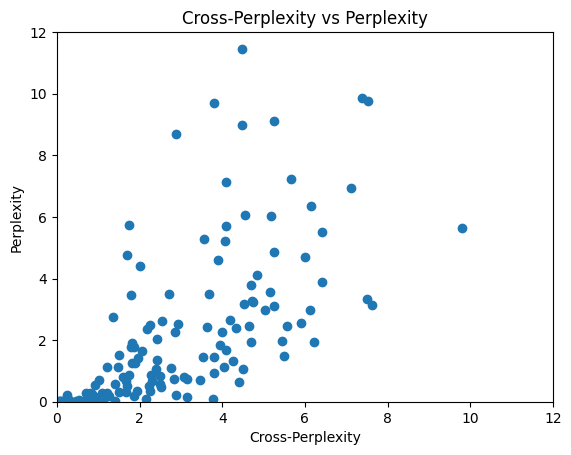

In [23]:
plt.scatter(xppl.float(), ppl.float())
plt.title("Cross-Perplexity vs Perplexity")
plt.xlabel("Cross-Perplexity")
plt.ylabel("Perplexity")
plt.xlim(0, 12)
plt.ylim(0, 12)
plt.show()


From the scatter plot, we see high density of tokens at the low perplexity and low cross-perplexity end, and more spread as perplexity increases.

Next, we investigate the behavior for a human-generated string from the [Ghostbuster dataset](https://github.com/vivek3141/ghostbuster-data/).

In [24]:
human = '''The healthcare industry typically draws sufficient attention to patients' education, especially when it comes to representatives of minority groups. That is why the article by McCurley et al. (2017) offers valuable information. The researchers demonstrate that Hispanic individuals deal with improved diabetes prevention when they participate in individual and group face-to-face sessions (McCurley et al., 2017). I believe that there is an apparent reason why such positive outcomes are achieved. It seems that face-to-face interventions are effective because patients have an opportunity to ask questions if they require explanations. Simultaneously, such educational sessions demonstrate that a patient is not unique with such a health issue. As a result, such interventions can improve people's morale, which, in turn, will lead to increased motivation to take preventive measures and protect health.'''

encoding = tokenize([human])

observer_logits, performer_logits = get_logits(encoding)

S = observer_logits.shape[-2]
V = observer_logits.shape[-1]

In [25]:
shifted_logits = observer_logits[..., :-1, :].contiguous()
shifted_labels = encoding.input_ids[..., 1:].contiguous()

ppl = loss_fn(shifted_logits.transpose(1, 2).to("cpu"), shifted_labels).float()

normalized_ppl = ppl / torch.max(ppl)

tokens = [tokenizer.decode([tok], clean_up_tokenization_spaces=False) for tok in encoding.input_ids.squeeze().tolist()]
html_output = generate_html(tokens, normalized_ppl)

display(HTML(html_output))

performer_probs = softmax_fn(performer_logits).view(-1, V).to("cpu")
observer_scores = observer_logits.view(-1, V).to("cpu")

xppl = loss_fn(observer_scores[:-1], performer_probs[:-1]).view(-1, S - 1).to("cpu").float()
normalized_xppl = xppl / torch.max(xppl)

html_output = generate_html(tokens, normalized_xppl)
display(HTML(html_output))

binocular_score = normalized_ppl / normalized_xppl
normalized_binocular_score = binocular_score / torch.max(binocular_score)

html_output = generate_html(tokens, normalized_binocular_score)
display(HTML(html_output))

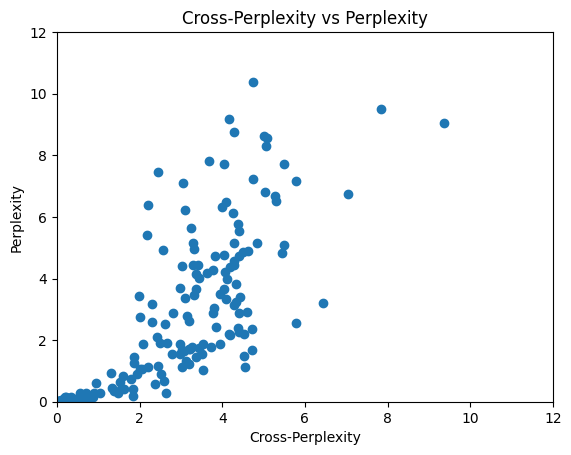

tensor([0.9926])

In [27]:
plt.scatter(xppl.float(), ppl.float())
plt.title("Cross-Perplexity vs Perplexity")
plt.xlabel("Cross-Perplexity")
plt.ylabel("Perplexity")
plt.xlim(0, 12)
plt.ylim(0, 12)
plt.show()

ppl.sum(1) / xppl.sum(1)

Compared to the previous perplexity scatter plot, there is much less spread and more values clustering around zero perplexity and cross-perplexity.

# Conclusion

The Binoculars method is promising as a new approach to detecting machine-generated text, with potential applications in academic integrity and content moderation. Binoculars sets the stage for more reliable and fair AI text detection tools, with a much lower FPR compared to other detection methods and services such as GPTZero.

<ol>
<li id="fn:1">
      <p>There seems to be a mistake in this paper's repository on GitHub in terms of performer/observer model choice. The performer model is used to calculate perplexity and to observe the observer model in the code, while the paper states that this is done by the observer.</p>
    </li>
    <a href="#fnref:1" class="reversefootnote" role="doc-backlink">↩</a>
</ol>